<a href="https://colab.research.google.com/github/Raeiss/Assignment-ML-Besher/blob/main/multi_classification_on_NB15_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier,RidgeClassifier
from sklearn.metrics import (precision_score, recall_score,f1_score)
from sklearn.metrics import average_precision_score

In [2]:
pip install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [3]:
#Importing libaries 
######## Base
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
######### Warning ##############
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
########## Sklearn #############
# Pre-processing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
# Models
from sklearn.linear_model import LogisticRegression     # Logistic Regression
from sklearn.naive_bayes import GaussianNB              # Naive Bayes
from sklearn.neighbors import KNeighborsClassifier      # KNN 
from sklearn.svm import SVC                             # SVC 
from sklearn import tree                                # CART - Sınıflandırma ve Regresyon Ağaçları
from sklearn.tree import DecisionTreeClassifier         # CART - Sınıflandırma ve Regresyon Ağaçları
from sklearn.ensemble import BaggingClassifier          # Baggingclassifier 
from sklearn.ensemble import VotingClassifier           # Voting 
from sklearn.ensemble import RandomForestClassifier     # Random Forest
from sklearn.ensemble import AdaBoostClassifier         # Ada Boost
from sklearn.ensemble import GradientBoostingClassifier # GBM - Gradient Boosting Machine
from xgboost import XGBClassifier                       # XGBoost | !pip install xgboost
from lightgbm import LGBMClassifier                     # LightGBM | !conda install -c conda-forge lightgbm
from catboost import CatBoostClassifier                 # CatBoost | !pip install catboost
#!pip install --upgrade nboost                           # NGBoost
#!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git
#from ngboost import NGBClassifier
#from ngboost.distns import k_categorical, Bernoulli

In [4]:
#Loading Data
train=pd.read_csv('/content/UNSW_NB15_training-set.csv')
test=pd.read_csv('/content/UNSW_NB15_testing-set.csv')

Train data length: 82332
Test data length: 175341


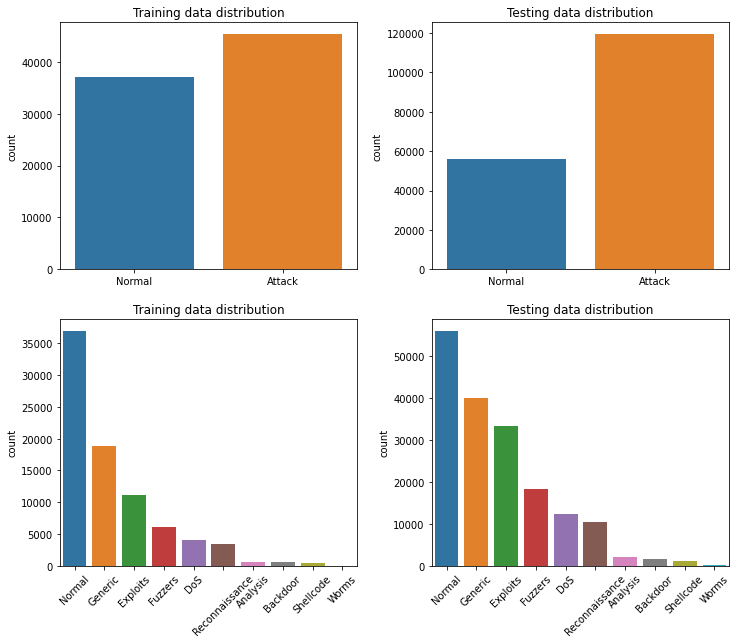

In [5]:
#Data Visualization
# Print the number of train / test samples
print(f"Train data length: {len(train)}")
print(f"Test data length: {len(test)}")

# Visualise the distribution of attacks and normal traffic

f, axes = plt.subplots(2, 2, figsize=(12, 10))

# Create the plots
sns.countplot(x="label", data=train, ax=axes[0,0])
sns.countplot(x="label", data=test, ax=axes[0,1])
sns.countplot(x="attack_cat", data=train, ax=axes[1,0], order = train['attack_cat'].value_counts().index)
sns.countplot(x="attack_cat", data=test, ax=axes[1,1], order = test['attack_cat'].value_counts().index)

# Set the plot titles
axes[0,0].set_title("Training data distribution")
axes[1,0].set_title("Training data distribution")
axes[0,1].set_title("Testing data distribution")
axes[1,1].set_title("Testing data distribution")

# Rotate xticks for readability
axes[1,0].tick_params('x', labelrotation=45)
axes[1,1].tick_params('x', labelrotation=45)

# Change the xtick labels for attack / normal
axes[0,0].set_xticklabels(["Normal", "Attack"])
axes[0,1].set_xticklabels(["Normal", "Attack"])

# Remove xlabels
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[1,0].set_xlabel("")
axes[1,1].set_xlabel("")

# Add some space between the plots for y labels
plt.subplots_adjust(wspace=0.25)

In [6]:
#Dataset Observation
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [7]:
train.shape,test.shape

((82332, 45), (175341, 45))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [9]:
#Data Preprocessing
#Null Value check
train.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [10]:
#Categorical variables
mask = (train.dtypes == np.object)
print(train.loc[:,mask].head())
list_cat = train.loc[:,mask].columns.tolist()
print(list_cat)
print(train.loc[:,mask].values)

  proto service state attack_cat
0   udp       -   INT     Normal
1   udp       -   INT     Normal
2   udp       -   INT     Normal
3   udp       -   INT     Normal
4   udp       -   INT     Normal
['proto', 'service', 'state', 'attack_cat']
[['udp' '-' 'INT' 'Normal']
 ['udp' '-' 'INT' 'Normal']
 ['udp' '-' 'INT' 'Normal']
 ...
 ['arp' '-' 'INT' 'Normal']
 ['arp' '-' 'INT' 'Normal']
 ['udp' '-' 'INT' 'Normal']]


In [11]:
#Numeric variables
mask = (train.dtypes != np.object)
print(train.loc[:,mask].head())
list_cat = train.loc[:,mask].columns.tolist()
print(list_cat)
train.loc[:,mask].describe()

   id       dur  spkts  dpkts  sbytes  dbytes         rate  sttl  dttl  \
0   1  0.000011      2      0     496       0   90909.0902   254     0   
1   2  0.000008      2      0    1762       0  125000.0003   254     0   
2   3  0.000005      2      0    1068       0  200000.0051   254     0   
3   4  0.000006      2      0     900       0  166666.6608   254     0   
4   5  0.000010      2      0    2126       0  100000.0025   254     0   

         sload  dload  sloss  dloss  sinpkt  dinpkt  sjit  djit  swin  stcpb  \
0  180363632.0    0.0      0      0   0.011     0.0   0.0   0.0     0      0   
1  881000000.0    0.0      0      0   0.008     0.0   0.0   0.0     0      0   
2  854400000.0    0.0      0      0   0.005     0.0   0.0   0.0     0      0   
3  600000000.0    0.0      0      0   0.006     0.0   0.0   0.0     0      0   
4  850400000.0    0.0      0      0   0.010     0.0   0.0   0.0     0      0   

   dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  trans_depth  \
0    

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.00000,8.233200e+04,8.233200e+04,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,4.753692,6.308556,755.394301,121.701284,6.363075e+03,535.180430,133.45908,1.084642e+09,1.073465e+09,128.28662,0.055925,0.029256,0.026669,139.528604,116.275069,0.094277,1.595372e+03,9.546604,1.369273,5.744923,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,64.649620,55.708021,6182.615732,1292.378499,5.672402e+04,3635.305383,127.35700,1.390860e+09,1.381996e+09,127.49137,0.116022,0.070854,0.055094,208.472063,244.600271,0.542922,3.806697e+04,11.090289,1.067188,8.418112,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,1.000000,0.000000,0.557929,0.010000,1.762392e+01,0.000000,255.00000,2.788886e+07,2.856975e+07,255.00000,0.000551,0.000441,0.000080,65.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,3.000000,2.000000,63.409444,63.136369,3.219332e+03,128.459914,255.00000,2.171310e+09,2.144205e+09,255.00000,0.105541,0.052596,0.048816,100.000000,87.000000,0.000000,0.000000e+00,11.000000,2.000000,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,60009.992000,57739.240000,1.483831e+06,463199.240100,255.00000,4.294950e+09,4.294881e+09,255.00000,3.821465,3.226788,2.928778,1504.000000,1500.000000,131.000000,5.242880e+06,63.000000,6.000000,59.000000,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [12]:
#Evaluation of the training dataset
# Check whether the positive label (1) match attack categories, and whether attack categories match labelled data.

# all(iterable) returns True if all elements of the iterable are considered as true values
print(all(((train.label == 1) & (train.attack_cat != 'Normal')) == (train.attack_cat != 'Normal')))
print(all(((train.attack_cat != 'Normal') & (train.label == 1)) == (train.label == 1)))

True
True


In [13]:
#number of occurrences for each attack category
train.attack_cat.value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [14]:
#Which protocols and services appear in the positively labelled entries?
mask = (train.label == 1)
print(train.loc[mask,:].service.value_counts())
print(train.loc[mask,:].proto.value_counts())

-           19778
dns         18299
http         4274
smtp         1216
ftp           794
ftp-data      447
pop3          423
ssl            30
snmp           29
dhcp           26
radius          7
irc             5
ssh             4
Name: service, dtype: int64
udp           21321
tcp           15247
unas           3515
ospf            638
sctp            324
              ...  
wb-mon           32
br-sat-mon       32
pvp              32
wsn              32
ib               31
Name: proto, Length: 129, dtype: int64


In [15]:
#In the negatively labelled ones?
mask = (train.label == 0)
print(train.loc[mask,:].service.value_counts())
print(train.loc[mask,:].proto.value_counts())


-           27375
http         4013
dns          3068
ftp-data      949
ftp           758
smtp          635
ssh           200
radius          2
Name: service, dtype: int64
tcp     27848
udp      8097
arp       987
ospf       38
igmp       30
Name: proto, dtype: int64


In [16]:
#Data cleaning
print(train.columns.values)
print(test.columns.values)

['id' 'dur' 'proto' 'service' 'state' 'spkts' 'dpkts' 'sbytes' 'dbytes'
 'rate' 'sttl' 'dttl' 'sload' 'dload' 'sloss' 'dloss' 'sinpkt' 'dinpkt'
 'sjit' 'djit' 'swin' 'stcpb' 'dtcpb' 'dwin' 'tcprtt' 'synack' 'ackdat'
 'smean' 'dmean' 'trans_depth' 'response_body_len' 'ct_srv_src'
 'ct_state_ttl' 'ct_dst_ltm' 'ct_src_dport_ltm' 'ct_dst_sport_ltm'
 'ct_dst_src_ltm' 'is_ftp_login' 'ct_ftp_cmd' 'ct_flw_http_mthd'
 'ct_src_ltm' 'ct_srv_dst' 'is_sm_ips_ports' 'attack_cat' 'label']
['id' 'dur' 'proto' 'service' 'state' 'spkts' 'dpkts' 'sbytes' 'dbytes'
 'rate' 'sttl' 'dttl' 'sload' 'dload' 'sloss' 'dloss' 'sinpkt' 'dinpkt'
 'sjit' 'djit' 'swin' 'stcpb' 'dtcpb' 'dwin' 'tcprtt' 'synack' 'ackdat'
 'smean' 'dmean' 'trans_depth' 'response_body_len' 'ct_srv_src'
 'ct_state_ttl' 'ct_dst_ltm' 'ct_src_dport_ltm' 'ct_dst_sport_ltm'
 'ct_dst_src_ltm' 'is_ftp_login' 'ct_ftp_cmd' 'ct_flw_http_mthd'
 'ct_src_ltm' 'ct_srv_dst' 'is_sm_ips_ports' 'attack_cat' 'label']


In [17]:
#Scaling the Data before doing anomoly detection
#As anomoly detection methods works better with scaled data, but there is no compulsory need to do so.
#Scale only continious data
df = pd.concat([train, test], ignore_index=True)

# Remove unwanted columns
df.drop(['id', 'attack_cat'], inplace=True, axis=1)

# Perform one-hot encoding on categorical columns and join back to main train_data
one_hot = pd.get_dummies(df[["proto", "state", "service"]])
df = df.join(one_hot)

# Remove the original categorical columns
df.drop(["proto", "state", "service"], inplace=True, axis=1)

# Re split the data back into train / test
train_data = df.iloc[0:175341, 0:]
test_data = df.iloc[175341:, 0:]

# Create y_train and then drop the label from the training data
y_train = np.array(train_data["label"])
train_data.drop(['label'], inplace=True, axis=1)

y_test = np.array(test_data["label"])
test_data.drop(['label'], inplace=True, axis=1)

# Use min-max scaler to scale the features to 0-1 range
# Only fit the scaler on the train data!!
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data)

# Scale the testing data
X_test = scaler.transform(test_data)

# Ensure our dataset splits are still correct
print(f"Train data shape: {X_train.shape} Train label shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape} Test label shape: {y_test.shape}")


Train data shape: (175341, 196) Train label shape: (175341,)
Test data shape: (82332, 196) Test label shape: (82332,)


In [18]:
#Machine Learning Analysis
#Logistic Regression
log = LogisticRegression(solver = "liblinear")
y_pred_log_fit = log.fit(X_train, y_train)
y_pred_log = y_pred_log_fit.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)

In [19]:
log_accuracy

0.9473108876257106

In [20]:
print ("Accuracy: " + str(accuracy_score(y_pred_log, y_test)))
print ("Precision: " + str(precision_score(y_pred_log, y_test)))
print ("Recall: " + str(recall_score(y_pred_log, y_test)))
print ("F1: " + str(f1_score(y_pred_log, y_test)))

Accuracy: 0.9473108876257106
Precision: 0.9540332563392504
Recall: 0.9902510100006623
F1: 0.9718048044925125


In [21]:
confusion_matrix(y_test, y_pred_log)

array([[ 3235,   736],
       [ 3602, 74759]])

In [22]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.47      0.81      0.60      3971
           1       0.99      0.95      0.97     78361

    accuracy                           0.95     82332
   macro avg       0.73      0.88      0.79     82332
weighted avg       0.97      0.95      0.95     82332



In [23]:
#AUROC Score
log_roc_auc_score = roc_auc_score(y_test, y_pred_log)

In [24]:
log_roc_auc_score

0.8843447571044023

In [25]:
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)

In [26]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_log)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, th_lr = precision_recall_curve(y_test, y_pred_log)

In [27]:
#AUPRC Score
log_auprc_score=average_precision_score(y_test,y_pred_log)

In [28]:
log_auprc_score

0.9884820920155214

In [29]:
# Ridge Classifier
rc = RidgeClassifier()
rc_fit = rc.fit(X_train, y_train)
y_pred_rc = rc_fit.predict(X_test)
rc_accuracy = accuracy_score(y_test, y_pred_rc)

In [30]:
rc_accuracy

0.9702788709128892

In [31]:
print ("Accuracy: " + str(accuracy_score(y_pred_rc, y_test)))
print ("Precision: " + str(precision_score(y_pred_rc, y_test)))
print ("Recall: " + str(recall_score(y_pred_rc, y_test)))
print ("F1: " + str(f1_score(y_pred_rc, y_test)))

Accuracy: 0.9702788709128892
Precision: 0.9834739219764934
Recall: 0.9852719322917999
F1: 0.9843721060934099


In [32]:
confusion_matrix(y_test, y_pred_rc)

array([[ 2819,  1152],
       [ 1295, 77066]])

In [33]:
print(classification_report(y_test, y_pred_rc))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      3971
           1       0.99      0.98      0.98     78361

    accuracy                           0.97     82332
   macro avg       0.84      0.85      0.84     82332
weighted avg       0.97      0.97      0.97     82332



In [34]:
#AUROC Score
rc_roc_auc_score = roc_auc_score(y_test, y_pred_rc)

In [35]:
rc_roc_auc_score

0.8466853367122457

In [36]:
fpr_rc, tpr_rc, thresholds_rc = roc_curve(y_test, y_pred_rc)
roc_auc_rc = auc(fpr_rc, tpr_rc)
precision_rc, recall_rc, th_rc = precision_recall_curve(y_test, y_pred_rc)

In [37]:
#AUPRC Score
rc_auprc_score = average_precision_score(y_test,y_pred_rc)

In [38]:
rc_auprc_score

0.984718251124288

In [39]:
#SGD Classifier
sgd = SGDClassifier()
sgd_fit = sgd.fit(X_train, y_train)
y_pred_sgd = sgd_fit.predict(X_test)
sgd_accuracy = accuracy_score(y_test, y_pred_sgd)

In [40]:
sgd_accuracy


0.9767526599621047

In [41]:
print ("Accuracy: " + str(accuracy_score(y_pred_sgd, y_test)))
print ("Precision: " + str(precision_score(y_pred_sgd, y_test)))
print ("Recall: " + str(recall_score(y_pred_sgd, y_test)))
print ("F1: " + str(f1_score(y_pred_sgd, y_test)))

Accuracy: 0.9767526599621047
Precision: 0.9910159390513138
Recall: 0.9846577148870884
F1: 0.9878265957717456


In [42]:
confusion_matrix(y_test, y_pred_sgd)

array([[ 2761,  1210],
       [  704, 77657]])

In [43]:
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.80      0.70      0.74      3971
           1       0.98      0.99      0.99     78361

    accuracy                           0.98     82332
   macro avg       0.89      0.84      0.87     82332
weighted avg       0.98      0.98      0.98     82332



In [44]:
#AUROC Score
sgd_roc_auc_score = roc_auc_score(y_test, y_pred_sgd)

In [45]:
sgd_roc_auc_score

0.8431533988885378

In [46]:
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_test, y_pred_sgd)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)
precision_sgd, recall_sgd, th_sgd = precision_recall_curve(y_test, y_pred_sgd)

In [47]:
#AUPRC Score
sgd_auprc_score = average_precision_score(y_test,y_pred_sgd)

In [48]:
sgd_auprc_score

0.9843622357240137

In [49]:
# Ensanmble Learning
import statistics
final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, statistics.mode( [y_pred_log[i],y_pred_rc[i], y_pred_sgd[i]]))

In [50]:
import seaborn
import matplotlib.pyplot as plt
 
def plot_confusion_matrix(cm,
                          target_names,
                          title,
                          cmap=None,
                          normalize=True):
    
    
    data = cm
    labels = target_names
    
    """Plot confusion matrix using heatmap.


    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title(title)
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt=".5g")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    ax.set(ylabel="True Label", xlabel='Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [51]:
ensamble_accuracy = accuracy_score(final_pred, y_test)

In [52]:
ensamble_accuracy

0.9717849681776223

In [53]:
print ("Accuracy: " + str(accuracy_score(final_pred, y_test)))
print ("Precision: " + str(precision_score(final_pred, y_test)))
print ("Recall: " + str(recall_score(final_pred, y_test)))
print ("F1: " + str(f1_score(final_pred, y_test)))

Accuracy: 0.9717849681776223
Precision: 0.9850818647031049
Recall: 0.9852704669032242
F1: 0.9851761567766596


In [54]:
fpr_en, tpr_en, thresholds_en = roc_curve(y_test, final_pred)
roc_auc_en = auc(fpr_en, tpr_en)
precision_en, recall_en, th_en = precision_recall_curve(y_test, final_pred)

In [55]:
roc_auc_en

0.8472374823389612

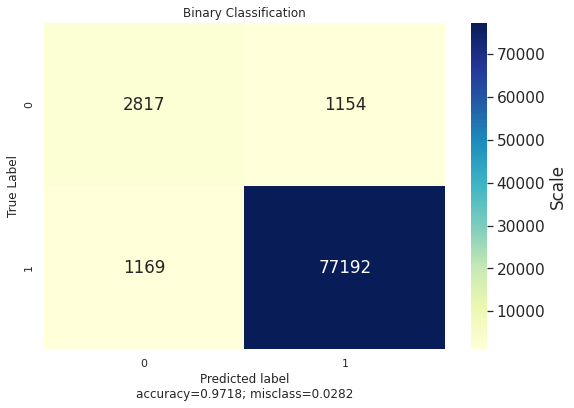

In [56]:
plot_confusion_matrix(cm = confusion_matrix(y_test, final_pred, labels=[0,1]), 
                      normalize    = False,
                      target_names = [0,1],
                      title        = "Binary Classification")

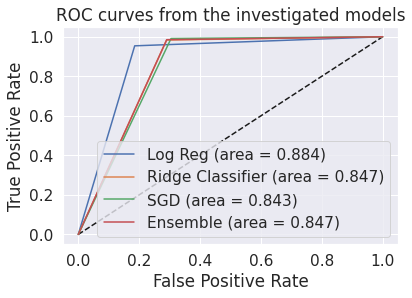

In [57]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Log Reg (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_rc, tpr_rc, label='Ridge Classifier (area = %0.3f)' % roc_auc_rc)
plt.plot(fpr_sgd, tpr_sgd, label='SGD (area = %0.3f)' % roc_auc_sgd)
plt.plot(fpr_en, tpr_en, label='Ensemble (area = %0.3f)' % roc_auc_en)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()

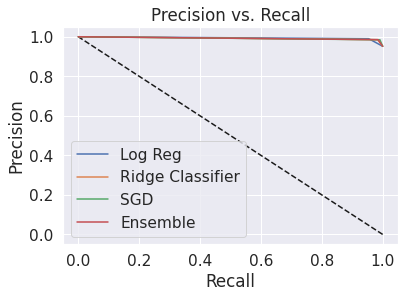

In [58]:
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(recall_lr, precision_lr, label='Log Reg')
plt.plot(recall_rc, precision_rc, label='Ridge Classifier')
plt.plot(recall_sgd, precision_sgd, label='SGD')
plt.plot(recall_en, precision_en, label='Ensemble')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

In [59]:
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim = None, cv=None, scoring=None, obj_line=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

        title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

        cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

         Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    scoring : string, callable or None, optional, default: None
              A string (see model evaluation documentation)
              or a scorer callable object / function with signature scorer(estimator, X, y)
              For Python 3.5 the documentation is here:
              http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

              For example, Log Loss is specified as 'neg_log_loss'

    obj_line : numeric or None (default: None)
               draw a horizontal line


    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).

        Citation
    --------
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    Usage
    -----
        plot_learning_curve(estimator = best_estimator,
                            title     = best_estimator_title,
                            X         = X_train,
                            y         = y_train,
                            Ylim      = (-1.1, 0.1), # neg_log_loss is negative
                            cv        = StatifiedCV, # CV generator
                            scoring   = scoring,     # eg., 'neg_log_loss'
                            obj_line  = obj_line,    # horizontal line
                            n_jobs    = n_jobs)      # how many CPUs

  plt.show()
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    from matplotlib import pyplot as plt

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    if obj_line:
        plt.axhline(y=obj_line, color='blue')

    plt.legend(loc="best")
    return plt



In [60]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

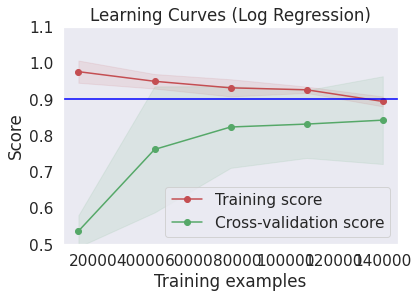

In [61]:
X, y = X_train, y_train

estimator = LogisticRegression(solver = "liblinear")
plot_learning_curve(estimator = estimator,
                    title     = "Learning Curves (Log Regression)",
                    X         = X,
                    y         = y,
                    ylim      = (0.5, 1.1),
                    cv        = StratifiedKFold(),
                    scoring   = 'accuracy',     
                    obj_line  = 0.90,    
                    n_jobs    = -1)  
plt.show()

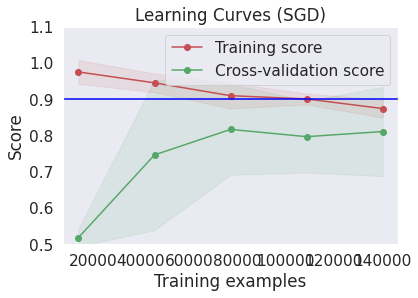

In [62]:
estimator = SGDClassifier()
plot_learning_curve(estimator = estimator,
                    title     = "Learning Curves (SGD)",
                    X         = X,
                    y         = y,
                    ylim      = (0.5, 1.1),
                    cv        = StratifiedKFold(),
                    scoring   = 'accuracy',     
                    obj_line  = 0.90,    
                    n_jobs    = -1)  
plt.show()


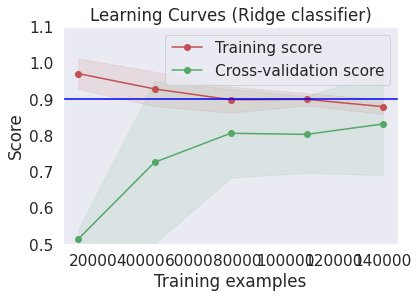

In [63]:
estimator = RidgeClassifier()
plot_learning_curve(estimator = estimator,
                    title     = "Learning Curves (Ridge classifier)",
                    X         = X,
                    y         = y,
                    ylim      = (0.5, 1.1),
                    cv        = StratifiedKFold(),
                    scoring   = 'accuracy',     
                    obj_line  = 0.90,    
                    n_jobs    = -1)  
plt.show()